<a href="https://colab.research.google.com/github/kimdonggyu2008/deep_daiv_-/blob/main/Avocodo_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#원본 코드

https://github.com/ncsoft/avocodo

#Avocodo 사전 설정


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wandb

In [3]:
!pip install pytorch_lightning

In [4]:
!pip install OmegaConf

In [5]:
!pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [6]:
# 공통으로 사용되는 라이브러리
import os
import glob
import json
import math
import time
import random
import argparse
import warnings
import itertools
from itertools import chain
from scipy import signal as sig
from scipy.signal.windows import kaiser
from omegaconf import OmegaConf
import sys



# 데이터 처리 관련 라이브러리
import numpy as np
from scipy.io.wavfile import read, write
from scipy import signal as sig
import librosa
from librosa.filters import mel as librosa_mel_fn
from librosa.util import normalize
from dataclasses import dataclass
from typing import List
from pytorch_lightning import LightningDataModule
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import TensorBoardLogger


# PyTorch 및 TensorBoard 관련 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torch.distributed import init_process_group
from torch.nn.parallel import DistributedDataParallel
torch.backends.cudnn.benchmark = True

# 시각화 및 플롯 관련 라이브러리
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt

# 유틸리티 관련 모듈
import shutil


In [7]:
import wandb
os.environ["WANDB_API_KEY"] = "513a1f0c050fa7f60a76b5232e904d8df397082e"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dkkim2008 (dkkim2008-hankuk-university-for-foreign-studies). Use `wandb login --relogin` to force relogin


True

#meldataset.py

In [8]:

MAX_WAV_VALUE = 32768.0


def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate


def dynamic_range_compression(x, C=1, clip_val=1e-5): #튀는 부분 처리
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1): #작은 부분 키우기
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5): #토치버전 튀는 부분 처리
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1): #토치버전 작은 부분 키우기
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes): #토치 버전 스펙트로그램 정규화
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes): #토치버전 스펙트로그램 비정규화
    output = dynamic_range_decompression_torch(magnitudes)
    return output


In [9]:
mel_basis = {}
hann_window = {}

In [10]:
def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.: #정규화 여부
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec


In [11]:
def get_dataset_filelist(
    input_wavs_dir,
    input_training_file,
    input_validation_file
):
    with open(input_training_file, 'r', encoding='utf-8') as fi:
        training_files = [os.path.join(input_wavs_dir, x.split('|')[0] + '.wav')
                          for x in fi.read().split('\n') if len(x) > 0]

    with open(input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]
    return training_files, validation_files


In [12]:
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, training_files, segment_size, n_fft, num_mels,
                 hop_size, win_size, sampling_rate,  fmin, fmax, split=True, shuffle=True, n_cache_reuse=1,
                 fmax_loss=None, fine_tuning=False, base_mels_path=None):
        self.audio_files = training_files
        random.seed(1234)
        if shuffle:
            random.shuffle(self.audio_files)
        self.segment_size = segment_size #1개의 샘플 내에서 묶을 신호의 갯수
        self.sampling_rate = sampling_rate
        self.split = split #segment_size로 자를지에 대한 여부
        self.n_fft = n_fft #fft에서 나눌 주파수 대역의 갯수
        self.num_mels = num_mels #멜 필터 사용 갯수
        self.hop_size = hop_size #나눠진 각 구간에 대한
        self.win_size = win_size #stft에서 분석할 샘플 갯수
        self.fmin = fmin #사용할 최소 주파수
        self.fmax = fmax #사용할 최대 주파수
        self.fmax_loss = fmax_loss #멜 손실 최댓값
        self.cached_wav = None
        self.n_cache_reuse = n_cache_reuse
        self._cache_ref_count = 0
        self.fine_tuning = fine_tuning #파인튜닝 여부
        self.base_mels_path = base_mels_path# 저장된 멜 스펙트로그램 데이터경로

    def __getitem__(self, index): #오디오 파일들 가져옴
        filename = self.audio_files[index]
        if self._cache_ref_count == 0:
            audio, sampling_rate = load_wav(filename) #[num_samples]
            audio = audio / MAX_WAV_VALUE
            if not self.fine_tuning: #파인 튜닝 여부에 따라 정규화, 첫 학습인 경우 npy
                audio = normalize(audio) * 0.95 #[num_samples]
            self.cached_wav = audio
            if sampling_rate != self.sampling_rate: #샘플레이트 맞추기
                raise ValueError("{} SR doesn't match target {} SR".format(
                    sampling_rate, self.sampling_rate))
            self._cache_ref_count = self.n_cache_reuse
        else:
            audio = self.cached_wav
            self._cache_ref_count -= 1

        audio = torch.FloatTensor(audio)#텐서화
        audio = audio.unsqueeze(0)#[1, num_samples]

        if not self.fine_tuning:
            if self.split:
                if audio.size(1) >= self.segment_size: #샘플 길이가 세그먼트 갯수보다 긴 경우
                    max_audio_start = audio.size(1) - self.segment_size
                    audio_start = random.randint(0, max_audio_start)
                    audio = audio[:, audio_start:audio_start+self.segment_size]
                    #랜덤 시작위치에서 세그먼트 길이까지 자름,[1,segment_size]
                else:
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')
                    #짧으면 오디오에 제로 패딩 추가
            mel = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                  self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax,
                                  center=False)
            #num_mels랑 hop_size, win_size로 멜로 만듦, [num_mels, num_frames]
        else:
            mel = np.load(
                os.path.join(self.base_mels_path, os.path.splitext(os.path.split(filename)[-1])[0] + '.npy'))
            mel = torch.from_numpy(mel)
                # [num_mels, num_frames]
            if len(mel.shape) < 3: #3개 값 안가지면, 차원 증강
                mel = mel.unsqueeze(0)
                # [1, num_mels,num_frames]

            if self.split:
                frames_per_seg = math.ceil(self.segment_size / self.hop_size) #프레임 갯수 계산
                # [1, num_mels, num_frames]
                if audio.size(1) >= self.segment_size:
                    mel_start = random.randint(0, mel.size(2) - frames_per_seg - 1)
                    mel = mel[:, :, mel_start:mel_start + frames_per_seg] #[ 1,num_mels,frames_per_seg]
                    audio = audio[:, mel_start * self.hop_size:(mel_start + frames_per_seg) * self.hop_size]
                    # [1,segment_size]
                else:
                    mel = torch.nn.functional.pad(mel, (0, frames_per_seg - mel.size(2)), 'constant') #[1,num_mels,num_frames]
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')
                    # [1,num_mels, frames_per_seg]
        mel_loss = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                   self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax_loss,
                                   center=False)
        # [1, segment_size] -> [num_mels, frames_per_seg]
        return (mel.squeeze(), audio.squeeze(0), filename, mel_loss.squeeze())

    def __len__(self):
        return len(self.audio_files)

#utils.py


In [13]:
def get_padding(kernel_size, dilation=1): #제로 패딩 추가
    return int((kernel_size*dilation - dilation)/2)


def init_weights(m, mean=0.0, std=0.01): #가중치 초기화
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)

#losses.py


In [14]:
def feature_loss(fmap_r, fmap_g): #생성된 특성 맵, 실제 특성 맵 비교
    loss = 0
    losses = []
    for dr, dg in zip(fmap_r, fmap_g): #각각에 대해 절댓값으로 비교
        for rl, gl in zip(dr, dg):
            _loss = torch.mean(torch.abs(rl - gl))
            loss += _loss
        losses.append(_loss)

    return loss*2, losses


def discriminator_loss(disc_real_outputs, disc_generated_outputs): #실제값, 생성값 로스값 비교
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
        r_loss = torch.mean((1-dr)**2)
        g_loss = torch.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs): #생성기 로스값
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = torch.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses

#pqmf.py

In [15]:
def design_prototype_filter(taps=62, cutoff_ratio=0.142, beta=9.0): #프로토타입 필터 예시
    """Design prototype filter for PQMF.
    This method is based on `A Kaiser window approach for the design of prototype
    filters of cosine modulated filterbanks`_.
    Args:
        taps (int): The number of filter taps.
        cutoff_ratio (float): Cut-off frequency ratio.
        beta (float): Beta coefficient for kaiser window.
    Returns:
        ndarray: Impluse response of prototype filter (taps + 1,).
    .. _`A Kaiser window approach for the design of prototype filters of cosine modulated filterbanks`:
        https://ieeexplore.ieee.org/abstract/document/681427
    """
    # check the arguments are valid, 제약조건
    assert taps % 2 == 0, "The number of taps mush be even number." #소수 지정
    assert 0.0 < cutoff_ratio < 1.0, "Cutoff ratio must be > 0.0 and < 1.0." #컷오프 비율

    # make initial filter
    omega_c = np.pi * cutoff_ratio #차단 주파수 계산
    with np.errstate(invalid="ignore"): #차단 주파수 기준으로 sinc함수로 필터 설계
        h_i = np.sin(omega_c * (np.arange(taps + 1) - 0.5 * taps)) / (
            np.pi * (np.arange(taps + 1) - 0.5 * taps)
        )
    h_i[taps // 2] = np.cos(0) * cutoff_ratio  # 완전 중심값의 경우, 분모가 0이므로 에러 발생하므로 예외처리

    # apply kaiser window
    w = kaiser(taps + 1, beta)# 양 옆으로 있고, 중간에 1개만 있으므로 +1, 베타를 가지는 카이저 윈도우
    h = h_i * w #

    return h

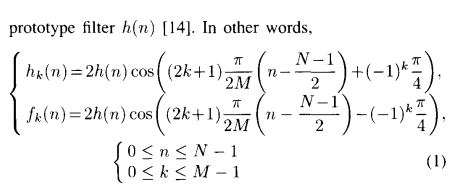

In [16]:
class PQMF(torch.nn.Module):
    """PQMF module.
    This module is based on `Near-perfect-reconstruction pseudo-QMF banks`_.
    .. _`Near-perfect-reconstruction pseudo-QMF banks`:
        https://ieeexplore.ieee.org/document/258122
    """

    def __init__(self, subbands=4, taps=62, cutoff_ratio=0.142, beta=9.0):
        """Initilize PQMF module.
        The cutoff_ratio and beta parameters are optimized for #subbands = 4.
        See dicussion in https://github.com/kan-bayashi/ParallelWaveGAN/issues/195.
        Args:
            subbands (int): The number of subbands.
            taps (int): The number of filter taps.
            cutoff_ratio (float): Cut-off frequency ratio.
            beta (float): Beta coefficient for kaiser window.
        """
        super(PQMF, self).__init__()

        # build analysis & synthesis filter coefficients
        h_proto = design_prototype_filter(taps, cutoff_ratio, beta) #필터 생성
        h_analysis = np.zeros((subbands, len(h_proto))) #서브 밴드 대역만큼 0으로 된 배열 생성
        h_synthesis = np.zeros((subbands, len(h_proto))) #합성도 동일한 크기의 배열 생성
        for k in range(subbands): #각 대역별로 분석, 합성을 진행
            h_analysis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    + (-1) ** k * np.pi / 4
                )
            )
            h_synthesis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    - (-1) ** k * np.pi / 4
                )
            )

        # convert to tensor
        analysis_filter = torch.from_numpy(h_analysis).float().unsqueeze(1)
        synthesis_filter = torch.from_numpy(h_synthesis).float().unsqueeze(0)

        # register coefficients as beffer
        self.register_buffer("analysis_filter", analysis_filter)
        self.register_buffer("synthesis_filter", synthesis_filter)

        # filter for downsampling & upsampling
        updown_filter = torch.zeros((subbands, subbands, subbands)).float()
        for k in range(subbands):
            updown_filter[k, k, 0] = 1.0
        self.register_buffer("updown_filter", updown_filter)
        self.subbands = subbands

        # keep padding info
        self.pad_fn = torch.nn.ConstantPad1d(taps // 2, 0.0)

    def analysis(self, x): #다운 샘플링
        """Analysis with PQMF.
        Args:
            x (Tensor): Input tensor (B, 1, T).
        Returns:
            Tensor: Output tensor (B, subbands, T // subbands).
        """
        x = F.conv1d(self.pad_fn(x), self.analysis_filter) #패딩 추가, [batch_size, subbands, t]
        return F.conv1d(x, self.updown_filter, stride=self.subbands)#(batch_size, sub_bands,t//sub_bands)

    def synthesis(self, x): #업 샘플링
        """Synthesis with PQMF.
        Args:
            x (Tensor): Input tensor (B, subbands, T // subbands).
        Returns:
            Tensor: Output tensor (B, 1, T).
        """
        # NOTE(kan-bayashi): Power will be dreased so here multipy by # subbands.
        #   Not sure this is the correct way, it is better to check again.
        # TODO(kan-bayashi): Understand the reconstruction procedure
        x = F.conv_transpose1d(
            x, self.updown_filter * self.subbands, stride=self.subbands
        )#[batch_size, subbands, t//subbands]
        return F.conv1d(self.pad_fn(x), self.synthesis_filter)#[batch_size, 1, t]

#CoMBD.py

In [17]:
class CoMBDBlock(torch.nn.Module):
    def __init__( #CoMBD 블록 선언
        self,
        h_u: List[int], #각 계층별 출력 갯수(히든 유닛) 리스트
        d_k: List[int], #각 계층의 커널 크기 리스트
        d_s: List[int], #각 계층의 스트라이드 리스트
        d_d: List[int], #각 계층의 dilation(확장 계수) 리스트
        d_g: List[int], #각 계층의 그룹 수 리스트
        d_p: List[int], #각 계층의 패딩 크기 리스트
        op_f: int, #프로젝션 계층의 출력 채널 크기
        op_k: int, #프로젝션 계층의 커널 크기
        op_g: int, #프로젝션 계층의 그룹 수
        use_spectral_norm=False #spectral normalization 적용여부
    ):
        super(CoMBDBlock, self).__init__()
        norm_f = weight_norm if use_spectral_norm is False else spectral_norm

        self.convs = nn.ModuleList()
        filters = [[1, h_u[0]]] #출력 필터 지정
        for i in range(len(h_u) - 1): #각 계층마다 필터 지정
            filters.append([h_u[i], h_u[i + 1]]) #각 필터 시작지점, 끝지점으로 묶기
        for _f, _k, _s, _d, _g, _p in zip(filters, d_k, d_s, d_d, d_g, d_p):#각 대역폭별로 사용될 데이터 묶기
            self.convs.append(norm_f(
                Conv1d(
                    in_channels=_f[0],
                    out_channels=_f[1],
                    kernel_size=_k,
                    stride=_s,
                    dilation=_d,
                    groups=_g,
                    padding=_p
                )
            ))
        self.projection_conv = norm_f( #제일 마지막 프로젝션 레이어
            Conv1d(
                in_channels=filters[-1][1],
                out_channels=op_f,
                kernel_size=op_k,
                groups=op_g
            )
        )

    def forward(self, x):
        fmap = []
        for block in self.convs:
            x = block(x) #블록
            x = F.leaky_relu(x, 0.2) #활성화 함수
            fmap.append(x) #묶어서 추가
        x = self.projection_conv(x)
        return x, fmap    #CoMBD 블록 반환


In [18]:
class CoMBD(torch.nn.Module):
    def __init__(self, h, pqmf_list=None, use_spectral_norm=False):
        super(CoMBD, self).__init__()
        self.h = h #하이퍼 파라미터 설정 객체
        if pqmf_list is not None: #대역 분할 있으면, 지정
            self.pqmf = pqmf_list
        else: #대역 분할이 없으면 LV1, LV2로 분할
            self.pqmf = [
                PQMF(*h.pqmf_config["lv2"]),
                PQMF(*h.pqmf_config["lv1"])
            ]

        self.blocks = nn.ModuleList() #CoMBD 블럭의 데이터 가져옴
        for _h_u, _d_k, _d_s, _d_d, _d_g, _d_p, _op_f, _op_k, _op_g in zip(
            h.combd_h_u,
            h.combd_d_k,
            h.combd_d_s,
            h.combd_d_d,
            h.combd_d_g,
            h.combd_d_p,
            h.combd_op_f,
            h.combd_op_k,
            h.combd_op_g,
        ):
            self.blocks.append(CoMBDBlock( #COMBD 블럭들 쌓기
                _h_u,
                _d_k,
                _d_s,
                _d_d,
                _d_g,
                _d_p,
                _op_f,
                _op_k,
                _op_g,
            ))

    def _block_forward(self, input, blocks, outs, f_maps): #순차적 통과
        for x, block in zip(input, blocks):
            out, f_map = block(x) #각 계층마다의 중간맵 출력
            outs.append(out)
            f_maps.append(f_map)
        return outs, f_maps

    def _pqmf_forward(self, ys, ys_hat): #PQMF를 통한 신호의 대역폭 분할
        # ys는 실제 신호 리스트 - training_step 파트에서 만들어짐
        # ys_hat은 생성된 신호 리스트
        #  ys = [
        #self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],  # PQMF Level 2
        #self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],  # PQMF Level 1
        #y  ] # 원래 입력 신호
        multi_scale_inputs = []
        multi_scale_inputs_hat = []
        for pqmf in self.pqmf: #lv1, lv2가 들어가있는 pqmf 객체 리스트에 다운샘플링
            multi_scale_inputs.append(  #analysis 함수는 일종의 다운샘플링
                pqmf.to(ys[-1]).analysis(ys[-1])[:, :1, :] #batch_size, subband,t
            )
            multi_scale_inputs_hat.append(
                pqmf.to(ys[-1]).analysis(ys_hat[-1])[:, :1, :]
            )

        outs_real = []
        f_maps_real = []
        # real
        # for hierarchical forward
        outs_real, f_maps_real = self._block_forward(
            ys, self.blocks, outs_real, f_maps_real)
        # for multi_scale forward
        outs_real, f_maps_real = self._block_forward(
            multi_scale_inputs, self.blocks[:-1], outs_real, f_maps_real)

        outs_fake = []
        f_maps_fake = []
        # predicted
        # for hierarchical forward
        outs_fake, f_maps_fake = self._block_forward(
            ys_hat, self.blocks, outs_fake, f_maps_fake)
        # for multi_scale forward
        outs_fake, f_maps_fake = self._block_forward(
            multi_scale_inputs_hat, self.blocks[:-1], outs_fake, f_maps_fake)

        return outs_real, outs_fake, f_maps_real, f_maps_fake

    def forward(self, ys, ys_hat):
        outs_real, outs_fake, f_maps_real, f_maps_fake = self._pqmf_forward(
            ys, ys_hat)
        return outs_real, outs_fake, f_maps_real, f_maps_fake

#SBD.py


In [19]:
class MDC(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        strides,
        kernel_size,
        dilations,
        use_spectral_norm=False
    ):
        super(MDC, self).__init__()
        norm_f = weight_norm if not use_spectral_norm else spectral_norm
        self.d_convs = nn.ModuleList()
        for _k, _d in zip(kernel_size, dilations):
            self.d_convs.append(
                norm_f(Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=_k,
                    dilation=_d,
                    padding=get_padding(_k, _d)
                ))
            )
        self.post_conv = norm_f(Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=strides,
            padding=get_padding(_k, _d)
        ))
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        _out = None
        for _l in self.d_convs:
            _x = torch.unsqueeze(_l(x), -1)
            _x = F.leaky_relu(_x, 0.2)
            if _out is None:
                _out = _x
            else:
                _out = torch.cat([_out, _x], axis=-1)
        x = torch.sum(_out, dim=-1)
        x = self.post_conv(x)
        x = F.leaky_relu(x, 0.2)  # @@

        return x



In [20]:
class SBDBlock(torch.nn.Module):
    def __init__(
        self,
        segment_dim,
        strides,
        filters,
        kernel_size,
        dilations,
        use_spectral_norm=False
    ):
        super(SBDBlock, self).__init__()
        norm_f = weight_norm if not use_spectral_norm else spectral_norm
        self.convs = nn.ModuleList()
        filters_in_out = [(segment_dim, filters[0])]
        for i in range(len(filters) - 1):
            filters_in_out.append([filters[i], filters[i + 1]])

        for _s, _f, _k, _d in zip(
            strides,
            filters_in_out,
            kernel_size,
            dilations
        ):
            self.convs.append(MDC(
                in_channels=_f[0],
                out_channels=_f[1],
                strides=_s,
                kernel_size=_k,
                dilations=_d,
                use_spectral_norm=use_spectral_norm
            ))
        self.post_conv = norm_f(Conv1d(
            in_channels=_f[1],
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=3 // 2
        ))  # @@

    def forward(self, x):
        fmap = []
        for _l in self.convs:
            x = _l(x)
            fmap.append(x)
        x = self.post_conv(x)  # @@

        return x, fmap



In [21]:
class MDCDConfig:
    def __init__(self, h):
        self.pqmf_params = h.pqmf_config["sbd"]
        self.f_pqmf_params = h.pqmf_config["fsbd"]
        self.filters = h.sbd_filters
        self.kernel_sizes = h.sbd_kernel_sizes
        self.dilations = h.sbd_dilations
        self.strides = h.sbd_strides
        self.band_ranges = h.sbd_band_ranges
        self.transpose = h.sbd_transpose
        self.segment_size = h.segment_size

In [22]:

class SBD(torch.nn.Module):
    def __init__(self, h, use_spectral_norm=False):
        super(SBD, self).__init__()
        self.config = MDCDConfig(h)
        self.pqmf = PQMF(
            *self.config.pqmf_params
        )
        if True in h.sbd_transpose:
            self.f_pqmf = PQMF(
                *self.config.f_pqmf_params
            )
        else:
            self.f_pqmf = None

        self.discriminators = torch.nn.ModuleList()

        for _f, _k, _d, _s, _br, _tr in zip(
            self.config.filters,
            self.config.kernel_sizes,
            self.config.dilations,
            self.config.strides,
            self.config.band_ranges,
            self.config.transpose
        ):
            if _tr:
                segment_dim = self.config.segment_size // _br[1] - _br[0]
            else:
                segment_dim = _br[1] - _br[0]

            self.discriminators.append(SBDBlock(
                segment_dim=segment_dim,
                filters=_f,
                kernel_size=_k,
                dilations=_d,
                strides=_s,
                use_spectral_norm=use_spectral_norm
            ))

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        y_in = self.pqmf.analysis(y)
        y_hat_in = self.pqmf.analysis(y_hat)
        if self.f_pqmf is not None:
            y_in_f = self.f_pqmf.analysis(y)
            y_hat_in_f = self.f_pqmf.analysis(y_hat)

        for d, br, tr in zip(
            self.discriminators,
            self.config.band_ranges,
            self.config.transpose
        ):
            if tr:
                _y_in = y_in_f[:, br[0]:br[1], :]
                _y_hat_in = y_hat_in_f[:, br[0]:br[1], :]
                _y_in = torch.transpose(_y_in, 1, 2)
                _y_hat_in = torch.transpose(_y_hat_in, 1, 2)
            else:
                _y_in = y_in[:, br[0]:br[1], :]
                _y_hat_in = y_hat_in[:, br[0]:br[1], :]
            y_d_r, fmap_r = d(_y_in)
            y_d_g, fmap_g = d(_y_hat_in)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs

#generator.py


In [23]:
class ResBlock(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights)

        self.convs2 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x):
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, 0.2)
            xt = c1(xt)
            xt = F.leaky_relu(xt, 0.2)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for _l in self.convs1:
            remove_weight_norm(_l)
        for _l in self.convs2:
            remove_weight_norm(_l)


In [24]:
class Generator(torch.nn.Module):
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.resblock = h.resblock
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            _ups = nn.ModuleList()
            for _i, (_u, _k) in enumerate(zip(u, k)):
                in_channel = h.upsample_initial_channel // (2**i)
                out_channel = h.upsample_initial_channel // (2**(i + 1))
                _ups.append(weight_norm(
                    ConvTranspose1d(in_channel, out_channel, _k, _u, padding=(_k - _u) // 2)))
            self.ups.append(_ups)

        self.resblocks = nn.ModuleList()
        self.conv_post = nn.ModuleList()
        for i in range(self.num_upsamples):
            ch = h.upsample_initial_channel // (2**(i + 1))
            temp = nn.ModuleList()
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                temp.append(resblock(h, ch, k, d))
            self.resblocks.append(temp)

            if self.h.projection_filters[i] != 0:
                self.conv_post.append(
                    weight_norm(
                        Conv1d(
                            ch, self.h.projection_filters[i],
                            self.h.projection_kernels[i], 1, padding=self.h.projection_kernels[i] // 2
                        )))
            else:
                self.conv_post.append(torch.nn.Identity())

        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        outs = []
        x = self.conv_pre(x)
        for i, (ups, resblocks, conv_post) in enumerate(zip(self.ups, self.resblocks, self.conv_post)):
            x = F.leaky_relu(x, 0.2)
            for _ups in ups:
                x = _ups(x)
            xs = None
            for j, resblock in enumerate(resblocks):
                if xs is None:
                    xs = resblock(x)
                else:
                    xs += resblock(x)
            x = xs / self.num_kernels
            if i >= (self.num_upsamples-3):
                _x = F.leaky_relu(x)
                _x = conv_post(_x)
                _x = torch.tanh(_x)
                outs.append(_x)
            else:
                x = conv_post(x)

        return outs

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for ups in self.ups:
            for _l in ups:
                remove_weight_norm(_l)
        for resblock in self.resblocks:
            for _l in resblock:
                _l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        for _l in self.conv_post:
            if not isinstance(_l, torch.nn.Identity):
                remove_weight_norm(_l)

#data_module.py

In [25]:
@dataclass
class AvocodoDataConfig:
    segment_size: int
    num_mels: int
    num_freq: int
    sampling_rate: int
    n_fft: int
    hop_size: int
    win_size: int
    fmin: int
    fmax: int
    batch_size: int
    num_workers: int

    fine_tuning: bool
    base_mels_path: str

    input_wavs_dir: str
    input_mels_dir: str
    input_training_file: str
    input_validation_file: str

In [26]:
class AvocodoData(LightningDataModule):
    def __init__(self, h: AvocodoDataConfig):
        super().__init__()
        self.save_hyperparameters(h)

    def prepare_data(self):
        '''
            download and prepare data
        '''
        self.training_filelist, self.validation_filelist = get_dataset_filelist(
            self.hparams.input_wavs_dir,
            self.hparams.input_training_file,
            self.hparams.input_validation_file
        )

    def setup(self, stage=None):
        self.trainset = MelDataset(
            self.training_filelist,
            self.hparams.segment_size,
            self.hparams.n_fft,
            self.hparams.num_mels,
            self.hparams.hop_size,
            self.hparams.win_size,
            self.hparams.sampling_rate,
            self.hparams.fmin,
            self.hparams.fmax,
            n_cache_reuse=0,
            fmax_loss=self.hparams.fmax_for_loss,
            fine_tuning=self.hparams.fine_tuning,
            base_mels_path=self.hparams.input_mels_dir
        )

    def train_dataloader(self):
        max_workers = os.cpu_count()  # 모든 CPU 코어 사용
        return DataLoader(
            self.trainset,
            num_workers=max_workers,
            shuffle=False,
            batch_size=self.hparams.batch_size,
            pin_memory=True,
            drop_last=True
        )

    @rank_zero_only
    def val_dataloader(self):
        validset = MelDataset(
            self.validation_filelist,
            self.hparams.segment_size,
            self.hparams.n_fft,
            self.hparams.num_mels,
            self.hparams.hop_size,
            self.hparams.win_size,
            self.hparams.sampling_rate,
            self.hparams.fmin,
            self.hparams.fmax,
            False,
            False,
            n_cache_reuse=0,
            fmax_loss=self.hparams.fmax_for_loss,
            fine_tuning=self.hparams.fine_tuning,
            base_mels_path=self.hparams.input_mels_dir
        )
        max_workers = os.cpu_count()  # 모든 CPU 코어 사용
        return DataLoader(validset, num_workers=max_workers, shuffle=False,
                          sampler=None,
                          batch_size=1,
                          pin_memory=True,
                          drop_last=True)

#lightning_module.py

In [27]:
from pytorch_lightning.loggers import WandbLogger

# WandB 프로젝트 초기화
wandb_logger = WandbLogger(project="avocodo_train", name="avocodo_training")

In [28]:
class Avocodo(LightningModule):
    def __init__(self, h):
        super().__init__()
        self.save_hyperparameters(h)

        # Model components
        self.pqmf_lv2 = PQMF(*self.hparams.pqmf_config["lv2"])
        self.pqmf_lv1 = PQMF(*self.hparams.pqmf_config["lv1"])

        self.generator = Generator(self.hparams.generator)
        self.combd = CoMBD(self.hparams.combd, [self.pqmf_lv2, self.pqmf_lv1])
        self.sbd = SBD(self.hparams.sbd)

        # Validation outputs storage
        self.validation_outputs = []

        # Manual optimization
        self.automatic_optimization = False

    def configure_optimizers(self):
        h = self.hparams.optimizer
        opt_g = torch.optim.AdamW(
            self.generator.parameters(),
            lr=h.learning_rate,
            betas=(h.adam_b1, h.adam_b2)
        )
        opt_d = torch.optim.AdamW(
            itertools.chain(self.combd.parameters(), self.sbd.parameters()),
            lr=h.learning_rate,
            betas=(h.adam_b1, h.adam_b2)
        )
        return [opt_g, opt_d]

    def forward(self, z):
        return self.generator(z)[-1]

    def training_step(self, batch, batch_idx):
        x, y, _, y_mel = batch
        y = y.unsqueeze(1)
        ys = [
            self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],
            self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],
            y
        ]
        y_g_hats = self.generator(x)

        # Get optimizers
        opt_g, opt_d = self.optimizers()

        # Train Generator
        opt_g.zero_grad()
        y_du_hat_r, y_du_hat_g, fmap_u_r, fmap_u_g = self.combd(ys, y_g_hats)
        loss_fm_u, _ = feature_loss(fmap_u_r, fmap_u_g)
        loss_gen_u, _ = generator_loss(y_du_hat_g)

        y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = self.sbd(y, y_g_hats[-1])
        loss_fm_s, _ = feature_loss(fmap_s_r, fmap_s_g)
        loss_gen_s, _ = generator_loss(y_ds_hat_g)

        # L1 Mel-Spectrogram Loss
        y_g_hat_mel = mel_spectrogram(
            y_g_hats[-1].squeeze(1),
            self.hparams.audio.n_fft,
            self.hparams.audio.num_mels,
            self.hparams.audio.sampling_rate,
            self.hparams.audio.hop_size,
            self.hparams.audio.win_size,
            self.hparams.audio.fmin,
            self.hparams.audio.fmax_for_loss
        )
        loss_mel = F.l1_loss(y_mel, y_g_hat_mel)
        self.log("train/loss_mel", loss_mel, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss_mel = loss_mel * self.hparams.loss_scale_mel

        g_loss = loss_gen_s + loss_gen_u + loss_fm_s + loss_fm_u + loss_mel
        self.manual_backward(g_loss)
        opt_g.step()
        self.log("train/g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Train Discriminator
        opt_d.zero_grad()
        detached_y_g_hats = [x.detach() for x in y_g_hats]

        y_du_hat_r, y_du_hat_g, _, _ = self.combd(ys, detached_y_g_hats)
        loss_disc_u, _, _ = discriminator_loss(y_du_hat_r, y_du_hat_g)

        y_ds_hat_r, y_ds_hat_g, _, _ = self.sbd(y, detached_y_g_hats[-1])
        loss_disc_s, _, _ = discriminator_loss(y_ds_hat_r, y_ds_hat_g)

        d_loss = loss_disc_s + loss_disc_u
        self.manual_backward(d_loss)
        opt_d.step()
        self.log("train/d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {"g_loss": g_loss, "d_loss": d_loss}

    def validation_step(self, batch, batch_idx):
        x, y, _, y_mel = batch
        y_g_hat = self(x)
        y_g_hat_mel = mel_spectrogram(
            y_g_hat.squeeze(1),
            self.hparams.audio.n_fft,
            self.hparams.audio.num_mels,
            self.hparams.audio.sampling_rate,
            self.hparams.audio.hop_size,
            self.hparams.audio.win_size,
            self.hparams.audio.fmin,
            self.hparams.audio.fmax_for_loss
        )
        val_loss = F.l1_loss(y_mel, y_g_hat_mel)
        self.validation_outputs.append(val_loss)

        # Log validation loss
        self.log("validation/loss_mel", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return val_loss

    def on_validation_epoch_end(self):
        if self.validation_outputs:
            avg_val_loss = torch.stack(self.validation_outputs).mean()
            self.log("validation/avg_loss", avg_val_loss, prog_bar=True, logger=True)
        self.validation_outputs.clear()



#train.py



In [29]:

class TBLogger(TensorBoardLogger):
    @rank_zero_only
    def log_metrics(self, metrics, step):
        metrics.pop('epoch', None)
        return super().log_metrics(metrics, step)



In [38]:
parser = argparse.ArgumentParser()

parser.add_argument('--group_name', default=None)
parser.add_argument('--input_wavs_dir', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs')
parser.add_argument('--input_mels_dir', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/mel_spectrogram')
parser.add_argument('--input_training_file',
                    default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt')
parser.add_argument('--input_validation_file',
                    default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt')
parser.add_argument('--config', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/config/avocodo_v1.json')
parser.add_argument('--training_epochs', default=5000, type=int)
parser.add_argument('--fine_tuning', default=False, type=bool)



if "ipykernel_launcher" in sys.argv[0]:
    sys.argv = [
        'script_name',
        '--group_name', 'default_group',
        '--input_wavs_dir', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs',
        '--input_mels_dir', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/mel_spectrogram',
        '--input_training_file', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt',
        '--input_validation_file', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt',
        '--config', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/config/avocodo_v1.json',
        '--training_epochs', '5000',
        '--fine_tuning', 'False'
    ]

In [56]:
data_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt'
#data_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt'
real_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs'
exists=[]
with open(data_dir, 'r') as file:
    datas = file.readlines()  # 각 줄을 리스트로 읽음

for data in datas:
    data = data.split('|')[0].strip()  # 파일 이름 추출
    data+=".wav"
    file_path = os.path.join(real_dir, data)  # 전체 경로 생성
    print(file_path)
    if not os.path.exists(file_path):  # 파일이 존재하지 않는 경우
        exists.append(data)

print("Missing files:", exists)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0040.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0041.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0042.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0043.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0044.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0045.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0046.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0047.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-0048.wav
/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs/LJ030-004

In [39]:
args = parser.parse_args()
print(f"Fine Tuning: {args.fine_tuning}")


usage: colab_kernel_launcher.py [-h] [--group_name GROUP_NAME] [--input_wavs_dir INPUT_WAVS_DIR]
                                [--input_mels_dir INPUT_MELS_DIR]
                                [--input_training_file INPUT_TRAINING_FILE]
                                [--input_validation_file INPUT_VALIDATION_FILE] [--config CONFIG]
                                [--training_epochs TRAINING_EPOCHS] [--fine_tuning FINE_TUNING]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-ace2bbdf-551a-4147-9c5d-969cf8d96cf2.json


SystemExit: 2

In [31]:
import torch
import librosa

# 샘플 Mel-spectrogram 생성 함수
def generate_mel_spectrogram(sample_rate=22050, n_fft=1024, hop_length=256, n_mels=80, duration=1.0):
    # 가상 오디오 데이터 생성 (White Noise)
    raw_audio = torch.randn(int(sample_rate * duration))  # 1초 길이의 오디오

    # Mel-spectrogram 변환
    mel_spectrogram = librosa.feature.melspectrogram(
        y=raw_audio.numpy(),
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_tensor = torch.tensor(mel_spectrogram).unsqueeze(0)  # 배치 차원 추가
    return mel_tensor

# 예시 데이터 준비
mel_input = generate_mel_spectrogram(duration=1.0)  # 1초 길이의 Mel-spectrogram
mel_input = mel_input.unsqueeze(0)  # 배치 차원 추가 (1, 80, Frames)
mel_input = mel_input.squeeze(1)
print(f"Input Shape: {mel_input.shape}")  # (1, 80, Frames)


Input Shape: torch.Size([1, 80, 87])


In [32]:
# Parse Arguments
a, unknown = parser.parse_known_args()

# OmegaConf 설정
OmegaConf.register_new_resolver("from_args", lambda x: getattr(a, x))
OmegaConf.register_new_resolver("dir", lambda base_dir, string: os.path.join(base_dir, string))
conf = OmegaConf.load(a.config)
OmegaConf.resolve(conf)


In [33]:

# 데이터 및 모델 초기화
dm = AvocodoData(conf.data)
model = Avocodo(conf.model)

# 모델 요약 출력
summary(
    model,
    input_data=mel_input,  # 입력 데이터 전달
    col_names=["input_size", "output_size", "num_params"],  # 표시할 열 선택
    col_width=20,
    depth=5  # 레이어 깊이 제한
)

limit_train_batches = 1.0
limit_val_batches = 1.0
log_every_n_steps = 50
max_epochs = conf.model.train.training_epochs

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [34]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',               # Validation 손실 기준
    dirpath='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/checkpoint',  # 체크포인트 저장 디렉토리
    filename='best-checkpoint-{epoch:02d}-{val_loss:.2f}',  # 파일 이름 패턴
    save_top_k=1,                     # 가장 좋은 k개의 모델만 저장
    mode='min',                       # 손실 기준으로 최소값 저장
)

# 조기 종료 콜백: Validation 손실 개선이 없으면 중단
early_stopping_callback = EarlyStopping(
    monitor='val_loss',              # Validation 손실 기준
    patience=100,                     # 몇 에포크 동안 개선 없으면 중단
    verbose=True,                    # 중단 시 메시지 출력
    mode='min'                       # 손실 기준으로 최소값 기준
)


In [35]:
trainer = Trainer(
    accelerator="gpu",
    devices="auto",
    max_epochs=max_epochs,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        RichProgressBar(
            refresh_rate=1,
            theme=RichProgressBarTheme(
                description="#AF81EB",
                progress_bar="#8BE9FE",
                progress_bar_finished="#8BE9FE",
                progress_bar_pulse="#1363DF",
                batch_progress="#AF81EB",
                time="#1363DF",
                processing_speed="#1363DF",
                metrics="#9BF9FE",
            )
        )
    ],
    # logger=TensorBoardLogger("logs", name="Avocodo"),
    logger=wandb_logger,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    log_every_n_steps=log_every_n_steps
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [36]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ pqmf_lv2  │ PQMF      │      0 │ train │
│ 1 │ pqmf_lv1  │ PQMF      │      0 │ train │
│ 2 │ generator │ Generator │ 13.9 M │ train │
│ 3 │ combd     │ CoMBD     │ 16.5 M │ train │
│ 4 │ sbd       │ SBD       │ 10.6 M │ train │
└───┴───────────┴───────────┴────────┴───────┘

Trainable params: 41.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 41.0 M                                                                                               
Total estimated model params size (MB): 164                                                                        
Modules in train mode: 320                                                                                         
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

#inference.py

In [ ]:

h = None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def get_mel(x):
    return mel_spectrogram(
        x,
        1024,
        80,
        22050,
        256,
        1024,
        0,
        8000
    )


In [ ]:


def inference(a, conf):#추론 config 로그 저장
    avocodo = Avocodo.load_from_checkpoint(
        f"{a.checkpoint_path}/version_{a.version}/checkpoints/{a.checkpoint_file_id}",
        map_location='cpu'
    )
    avocodo_data = AvocodoData(conf.audio)
    avocodo_data.prepare_data()
    validation_dataloader = avocodo_data.val_dataloader()

    output_path = f'{a.output_dir}/version_{a.version}/'
    os.makedirs(output_path, exist_ok=True)

    avocodo.generator.to(a.device)
    avocodo.generator.remove_weight_norm()

    m = torch.jit.script(avocodo.generator)
    torch.jit.save(
        m,
        os.path.join(output_path, "scripted.pt")
    )

    with torch.no_grad():
        for i, batch in enumerate(validation_dataloader):
            mels, _, file_ids, _ = batch

            y_g_hat = avocodo(mels.to(a.device))

            for _y_g_hat, file_id in zip(y_g_hat, file_ids):
                audio = _y_g_hat.squeeze(0)
                audio = audio * MAX_WAV_VALUE
                audio = audio.cpu().numpy().astype('int16')

                output_file = os.path.join(
                    output_path,
                    file_id.split('/')[-1]
                )
                print(file_id)
                write(output_file, conf.audio.sampling_rate, audio)
    print('Done inference')


In [ ]:


def main():
    print('Initializing Inference Process..')

    parser = argparse.ArgumentParser()
    parser.add_argument('--checkpoint_path', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/checkpoint')
    parser.add_argument('--version', type=int, required=True)
    parser.add_argument('--checkpoint_file_id', type=str, default='', required=True)
    parser.add_argument('--output_dir', type=str, default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/result')
    parser.add_argument('--script', type=bool, default=True)
    parser.add_argument('--device', type=str, default='cuda')
    a = parser.parse_args()

    conf = OmegaConf.load(os.path.join(a.checkpoint_path, f"version_{a.version}", "hparams.yaml"))
    inference(a, conf)

In [ ]:
if __name__ == '__main__':
    main()